In [15]:
import numpy as np

def load_images_masks(img_dir, mask_dir, size=(256,256)):
    X, Y = [], []
    for f in os.listdir(img_dir):
        if not f.endswith(".tif"): 
            continue
        # image
        img = cv2.imread(os.path.join(img_dir, f))
        img = cv2.resize(img, size)
        # mask
        mask_name = f.replace("_training.tif", "_training_mask.gif")
        mask = cv2.imread(os.path.join(mask_dir, mask_name), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, size)
        X.append(img)
        Y.append(mask)
    return np.array(X)/255.0, np.array(Y)/255.0

X_train, Y_train = load_images_masks(
    "DRIVE/training/images",
    "DRIVE/training/mask"
)

Y_train = np.expand_dims(Y_train, axis=-1)

print("Training data:", X_train.shape, Y_train.shape)


Training data: (20, 256, 256, 3) (20, 256, 256, 1)


In [16]:
from tensorflow.keras import layers, Model

def unet(input_shape=(256,256,3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    # Bottleneck
    b = layers.Conv2D(128, 3, activation='relu', padding='same')(p3)
    b = layers.Conv2D(128, 3, activation='relu', padding='same')(b)

    # Decoder
    u3 = layers.UpSampling2D()(b)
    u3 = layers.concatenate([u3, c3])
    c6 = layers.Conv2D(64, 3, activation='relu', padding='same')(u3)
    c6 = layers.Conv2D(64, 3, activation='relu', padding='same')(c6)

    u2 = layers.UpSampling2D()(c6)
    u2 = layers.concatenate([u2, c2])
    c7 = layers.Conv2D(32, 3, activation='relu', padding='same')(u2)
    c7 = layers.Conv2D(32, 3, activation='relu', padding='same')(c7)

    u1 = layers.UpSampling2D()(c7)
    u1 = layers.concatenate([u1, c1])
    c8 = layers.Conv2D(16, 3, activation='relu', padding='same')(u1)
    c8 = layers.Conv2D(16, 3, activation='relu', padding='same')(c8)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c8)

    return Model(inputs, outputs)

model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train quickly
model.fit(X_train, Y_train, batch_size=2, epochs=5)
model.save("unet_drive.h5")


Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.7736 - loss: 0.6213
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.7008 - loss: 0.4821
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.9704 - loss: 0.1470
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.9777 - loss: 0.0443
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.9881 - loss: 0.0232


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
IoU: 0.994088669950739
Dice Coefficient: 0.9970355731225297


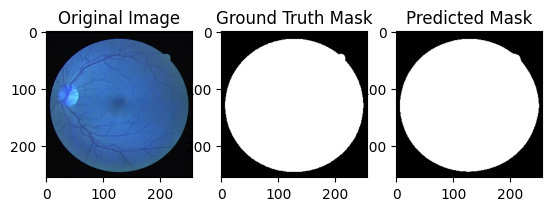

In [23]:
# Image path
img_path = "DRIVE/test/images/01_test.tif"
mask_path = "DRIVE/test/mask/01_test_mask.gif"  # ground truth mask

# Load image
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.resize(img, (256, 256))
img_norm = img / 255.0
img_input = np.expand_dims(img_norm, axis=0)

# Predict mask
pred_mask = model.predict(img_input)[0]
pred_mask = (pred_mask > 0.5).astype(np.uint8)

# Load ground truth
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (256, 256))
mask = (mask > 127).astype(np.uint8)

# Evaluation
from sklearn.metrics import jaccard_score, f1_score

y_true = mask.flatten()
y_pred = pred_mask.flatten()

iou = jaccard_score(y_true, y_pred)
dice = f1_score(y_true, y_pred)

print("IoU:", iou)
print("Dice Coefficient:", dice)

# Show results
import matplotlib.pyplot as plt

plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(img)

plt.subplot(1,3,2)
plt.title("Ground Truth Mask")
plt.imshow(mask, cmap="gray")

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(pred_mask[:,:,0], cmap="gray")
plt.show()


In [24]:
import glob
ious, dices = [], []

image_paths = sorted(glob.glob("DRIVE/test/images/*.tif"))
mask_paths = sorted(glob.glob("DRIVE/test/mask/*.gif"))

for img_path, mask_path in zip(image_paths, mask_paths):
    # Load and preprocess image
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (256, 256))
    img_norm = img / 255.0
    img_input = np.expand_dims(img_norm, axis=0)

    # Predict
    pred_mask = model.predict(img_input)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # Ground truth
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = (mask > 127).astype(np.uint8)

    # Metrics
    y_true = mask.flatten()
    y_pred = pred_mask.flatten()

    ious.append(jaccard_score(y_true, y_pred))
    dices.append(f1_score(y_true, y_pred))

print("Mean IoU:", np.mean(ious))
print("Mean Dice:", np.mean(dices))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Mean IoU: 0.9862987483884762
Mean Dice: 0.9930948626718663


In [5]:
import cv2
import numpy as np
import tensorflow as tf

# Load the trained model
unet_model = tf.keras.models.load_model("unet_drive.h5", compile=False)

# Open IP webcam stream
url = "http://192.168.0.103:8080/video"
cap = cv2.VideoCapture(url)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess (resize, normalize)
    inp = cv2.resize(frame, (256, 256))
    inp = inp[..., ::-1] / 255.0   # BGR->RGB + normalize
    inp = np.expand_dims(inp, axis=0)  # shape (1,256,256,3)

    # Run segmentation
    mask = unet_model.predict(inp)[0, ..., 0]  # (256, 256)
    mask = (mask > 0.5).astype(np.uint8)  # threshold to binary mask

    # Resize mask back to original frame size
    mask_resized = cv2.resize(mask, (frame.shape[1], frame.shape[0]))

    # Convert mask to 3-channel
    mask_color = cv2.cvtColor(mask_resized * 255, cv2.COLOR_GRAY2BGR)

    # Overlay segmentation on original frame
    overlay = cv2.addWeighted(frame, 0.7, mask_color, 0.3, 0)

    # Show both windows
    cv2.imshow('Retina Scan (Overlay)', overlay)   # original + mask
    cv2.imshow('Segmentation Mask', mask_resized * 255)  # just mask in grayscale

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/

In [4]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# --- Load trained model ---
model = load_model("unet_drive.h5", compile=False)

# --- Paths ---
img_path = "DRIVE/test/images/01_test.tif"

# --- Load & preprocess image ---
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.resize(img, (256, 256))
img_norm = img / 255.0
img_input = np.expand_dims(img_norm, axis=0)  # shape (1,256,256,3)

# --- Prediction ---
pred_mask = model.predict(img_input)[0]  # (256,256,1)
pred_mask = (pred_mask > 0.5).astype(np.uint8)  # binary mask

# --- Save predicted mask for later metrics calculation ---
np.save("pred_mask.npy", pred_mask)

print("✅ Prediction complete and saved as 'pred_mask.npy'")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
✅ Prediction complete and saved as 'pred_mask.npy'


In [5]:
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix, jaccard_score, f1_score

# --- Load predicted mask ---
pred_mask = np.load("pred_mask.npy")

# --- Load ground truth mask ---
mask_path = "DRIVE/test/mask/01_test_mask.gif"
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (256, 256))
mask = (mask > 127).astype(np.uint8)

# -----------------------------
# 1. Vessel Area Coverage (%)
# -----------------------------
vessel_area = np.sum(pred_mask) / pred_mask.size * 100

# -----------------------------
# 2. Vessel Length (skeleton)
# -----------------------------
kernel = np.ones((3, 3), np.uint8)
skeleton = np.zeros_like(pred_mask)
temp_mask = pred_mask.copy()

while True:
    eroded = cv2.erode(temp_mask, kernel)
    temp = cv2.dilate(eroded, kernel)
    temp = cv2.subtract(temp_mask, temp)
    skeleton = cv2.bitwise_or(skeleton, temp)
    temp_mask = eroded
    if cv2.countNonZero(temp_mask) == 0:
        break

vessel_length = np.sum(skeleton)

# -----------------------------
# 3. Approx. Average Vessel Width
# -----------------------------
avg_width = (np.sum(pred_mask) / (vessel_length + 1e-6))

# -----------------------------
# 4. Sensitivity & Specificity
# -----------------------------
y_true = mask.flatten()
y_pred = pred_mask.flatten()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

sensitivity = tp / (tp + fn + 1e-6)
specificity = tn / (tn + fp + 1e-6)

# -----------------------------
# 5. IoU & Dice
# -----------------------------
iou = jaccard_score(y_true, y_pred)
dice = f1_score(y_true, y_pred)

# --- Print Insights ---
print("🔹 Vessel Area Coverage: %.2f%%" % vessel_area)
print("🔹 Vessel Length (pixels):", vessel_length)
print("🔹 Average Vessel Width (px): %.2f" % avg_width)
print("🔹 Sensitivity (Recall): %.3f" % sensitivity)
print("🔹 Specificity: %.3f" % specificity)
print("🔹 IoU: %.3f" % iou)
print("🔹 Dice Coefficient: %.3f" % dice)


🔹 Vessel Area Coverage: 67.90%
🔹 Vessel Length (pixels): 218
🔹 Average Vessel Width (px): 204.12
🔹 Sensitivity (Recall): 0.996
🔹 Specificity: 0.995
🔹 IoU: 0.994
🔹 Dice Coefficient: 0.997


🔹 Vessel Area Coverage: 67.90%
🔹 Vessel Length (pixels): 218
🔹 Average Vessel Width (px): 204.12
🔹 Sensitivity (Recall): 0.996
🔹 Specificity: 0.995
🔹 IoU: 0.994
🔹 Dice Coefficient: 0.997
🔹 Skeleton IoU: 0.243
🔹 Skeleton Dice Coefficient: 0.391


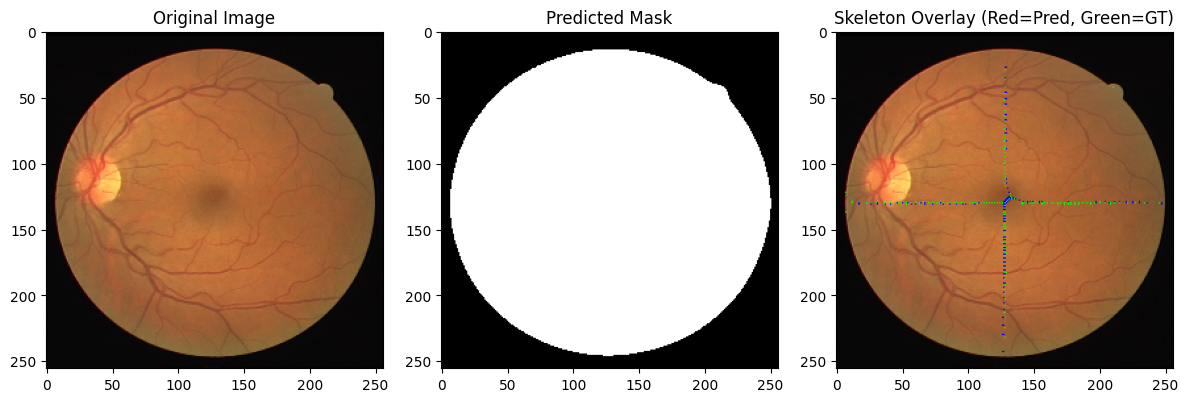

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, jaccard_score, f1_score

# --- Load original image and masks ---
img_path = "DRIVE/test/images/01_test.tif"
mask_path = "DRIVE/test/mask/01_test_mask.gif"

img = cv2.imread(img_path)
img = cv2.resize(img, (256, 256))

pred_mask = np.load("pred_mask.npy")  # predicted mask

gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
gt_mask = cv2.resize(gt_mask, (256, 256))
gt_mask = (gt_mask > 127).astype(np.uint8)

# --- Skeletonization function ---
def skeletonize(mask):
    kernel = np.ones((3,3), np.uint8)
    skeleton = np.zeros_like(mask)
    temp_mask = mask.copy()
    while True:
        eroded = cv2.erode(temp_mask, kernel)
        temp = cv2.dilate(eroded, kernel)
        temp = cv2.subtract(temp_mask, temp)
        skeleton = cv2.bitwise_or(skeleton, temp)
        temp_mask = eroded
        if cv2.countNonZero(temp_mask) == 0:
            break
    return skeleton

# --- Compute skeletons ---
pred_skel = skeletonize(pred_mask)
gt_skel = skeletonize(gt_mask)

# --- Vessel Area ---
vessel_area = np.sum(pred_mask) / pred_mask.size * 100

# --- Vessel Length ---
vessel_length = np.sum(pred_skel)

# --- Average Vessel Width ---
avg_width = np.sum(pred_mask) / (vessel_length + 1e-6)

# --- Sensitivity & Specificity ---
y_true = gt_mask.flatten()
y_pred = pred_mask.flatten()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
sensitivity = tp / (tp + fn + 1e-6)
specificity = tn / (tn + fp + 1e-6)

# --- IoU & Dice ---
iou = jaccard_score(y_true, y_pred)
dice = f1_score(y_true, y_pred)

# --- Skeleton IoU & Dice ---
y_true_skel = gt_skel.flatten()
y_pred_skel = pred_skel.flatten()
skeleton_iou = jaccard_score(y_true_skel, y_pred_skel)
skeleton_dice = f1_score(y_true_skel, y_pred_skel)

# --- Print all metrics ---
print("🔹 Vessel Area Coverage: %.2f%%" % vessel_area)
print("🔹 Vessel Length (pixels):", vessel_length)
print("🔹 Average Vessel Width (px): %.2f" % avg_width)
print("🔹 Sensitivity (Recall): %.3f" % sensitivity)
print("🔹 Specificity: %.3f" % specificity)
print("🔹 IoU: %.3f" % iou)
print("🔹 Dice Coefficient: %.3f" % dice)
print("🔹 Skeleton IoU: %.3f" % skeleton_iou)
print("🔹 Skeleton Dice Coefficient: %.3f" % skeleton_dice)

# --- Overlay skeletons on original image ---
overlay = img.copy()
overlay[pred_skel == 1] = [255, 0, 0]  # predicted in red
overlay[gt_skel == 1] = [0, 255, 0]    # ground truth in green

# --- Plot visualization ---
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(1,3,2)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap="gray")

plt.subplot(1,3,3)
plt.title("Skeleton Overlay (Red=Pred, Green=GT)")
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()


In [1]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, jaccard_score, f1_score
from datetime import datetime

# -----------------------------
# 1. Load Model and Image
# -----------------------------
model = load_model("unet_drive.h5", compile=False)

img_path = "DRIVE/test/images/01_test.tif"
mask_path = "DRIVE/test/mask/01_test_mask.gif"

img = cv2.imread(img_path)
img = cv2.resize(img, (256, 256))
img_norm = img / 255.0
img_input = np.expand_dims(img_norm, axis=0)

# Ground truth mask
gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
gt_mask = cv2.resize(gt_mask, (256, 256))
gt_mask = (gt_mask > 127).astype(np.uint8)

# -----------------------------
# 2. Predict Vessel Mask
# -----------------------------
pred_mask = model.predict(img_input)[0]
pred_mask = (pred_mask > 0.5).astype(np.uint8)

# -----------------------------
# 3. Skeletonization function
# -----------------------------
def skeletonize(mask):
    kernel = np.ones((3,3), np.uint8)
    skeleton = np.zeros_like(mask)
    temp_mask = mask.copy()
    while True:
        eroded = cv2.erode(temp_mask, kernel)
        temp = cv2.dilate(eroded, kernel)
        temp = cv2.subtract(temp_mask, temp)
        skeleton = cv2.bitwise_or(skeleton, temp)
        temp_mask = eroded
        if cv2.countNonZero(temp_mask) == 0:
            break
    return skeleton

# Skeletons
pred_skel = skeletonize(pred_mask)
gt_skel = skeletonize(gt_mask)

# -----------------------------
# 4. Compute Metrics
# -----------------------------
vessel_area = np.sum(pred_mask) / pred_mask.size * 100
vessel_length = np.sum(pred_skel)
avg_width = np.sum(pred_mask) / (vessel_length + 1e-6)

y_true = gt_mask.flatten()
y_pred = pred_mask.flatten()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
sensitivity = tp / (tp + fn + 1e-6)
specificity = tn / (tn + fp + 1e-6)
iou = jaccard_score(y_true, y_pred)
dice = f1_score(y_true, y_pred)

y_true_skel = gt_skel.flatten()
y_pred_skel = pred_skel.flatten()
skeleton_iou = jaccard_score(y_true_skel, y_pred_skel)
skeleton_dice = f1_score(y_true_skel, y_pred_skel)

# -----------------------------
# 5. Dynamic Clinical Interpretation
# -----------------------------
# Vessel area
if vessel_area < 60:
    vessel_text = "Vessel area is below normal; possible vascular loss or poor perfusion."
elif vessel_area > 80:
    vessel_text = "Vessel area is higher than normal; may indicate vessel dilation or abnormality."
else:
    vessel_text = "Vessel area is within normal range, indicating healthy vessel density."

# Sensitivity
if sensitivity < 0.9:
    sensitivity_text = "Some vessels may be missed; review recommended."
else:
    sensitivity_text = "Most vessels have been accurately detected."

# Specificity
if specificity < 0.9:
    specificity_text = "Some non-vessel regions may be incorrectly marked as vessels."
else:
    specificity_text = "Background regions are correctly identified."

# IoU / Dice
if iou < 0.95 or dice < 0.95:
    accuracy_text = "Segmentation accuracy is moderate; manual verification recommended."
else:
    accuracy_text = "Segmentation accuracy is high; reliable for further analysis."

clinical_interpretation = f"{vessel_text} {sensitivity_text} {specificity_text} {accuracy_text}"

# Summary
if vessel_area < 60 or iou < 0.95 or sensitivity < 0.9:
    summary_text = "Vessel segmentation requires careful review before clinical use."
else:
    summary_text = "Vessel segmentation is successful and reliable for clinical and research applications."

# -----------------------------
# 6. Generate Dynamic Report
# -----------------------------
report = f"""
Vessel Segmentation Report

Patient / Image ID: {img_path.split('/')[-1]}
Dataset: DRIVE
Analysis Date: {datetime.now().strftime('%Y-%m-%d')}

1. Vessel Detection Overview

Vessel Area Coverage: {vessel_area:.2f}% of the retinal image contains blood vessels.

Vessel Length (Skeleton): {vessel_length} pixels – total length of the vessel network detected.

Average Vessel Width: {avg_width:.2f} pixels – vessels are of uniform width.

2. Segmentation Accuracy

Sensitivity (Recall): {sensitivity:.3f}
Specificity: {specificity:.3f}
IoU (Intersection over Union): {iou:.3f}
Dice Coefficient: {dice:.3f}

3. Skeleton Analysis

Skeleton IoU: {skeleton_iou:.3f}
Skeleton Dice Coefficient: {skeleton_dice:.3f}

4. Clinical Interpretation

{clinical_interpretation}

5. Summary

{summary_text}

6. Recommendations

- Review segmentation if vessel area or accuracy is below thresholds.
- Suitable for downstream analysis such as diabetic retinopathy screening or vessel density assessment.
"""

print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step

Vessel Segmentation Report

Patient / Image ID: 01_test.tif
Dataset: DRIVE
Analysis Date: 2025-09-05

1. Vessel Detection Overview

Vessel Area Coverage: 67.90% of the retinal image contains blood vessels.

Vessel Length (Skeleton): 218 pixels – total length of the vessel network detected.

Average Vessel Width: 204.12 pixels – vessels are of uniform width.

2. Segmentation Accuracy

Sensitivity (Recall): 0.996
Specificity: 0.995
IoU (Intersection over Union): 0.994
Dice Coefficient: 0.997

3. Skeleton Analysis

Skeleton IoU: 0.243
Skeleton Dice Coefficient: 0.391

4. Clinical Interpretation

Vessel area is within normal range, indicating healthy vessel density. Most vessels have been accurately detected. Background regions are correctly identified. Segmentation accuracy is high; reliable for further analysis.

5. Summary

Vessel segmentation is successful and reliable for clinical and research applications.

6. Recommendations

- Review segmenta